## 1. 필요한 패키지 로드

In [2]:
# Viola-Jones algorithm stencil code 
# Written by Soochahn Lee for Computer Vision @ Kookmin University

import csv
import sys
import argparse
import numpy as np
import scipy.io as scio

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

%load_ext autoreload 
%autoreload 2

from skimage import io, filters, feature, img_as_float32
from skimage.transform import rescale
from skimage.color import rgb2gray

import student as student

### size of haar_like_feature ###
hlf_sz = (18,18)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. 실험용 데이터 파일 로딩 함수 정의

실험용 영상 DB를 읽어오고, 영상 사이즈, 컬러/흑백, 픽셀 값 범위 ([0-255]->[0.0 1.0]) 등 포맷을 적절하게 조정하는 함수를 구현하시오. (해당 함수 자유롭게 외부 자료 참고하여 작성하여 됨을

In [3]:
# load positve and negative dataset
DATA_NUM = 1000
# positive data: size n_p x h x w, where n_p = number of positive images and h_i, w_i are width and height of images
data_pos = student.load_folder_imgs('../data/pos', hlf_sz)[:DATA_NUM,:,:]
# negative data: size n_n x h x w, where n_n = number of negative images and h_i, w_i are width and height of images
data_neg = student.load_folder_imgs('../data/neg', hlf_sz)[:DATA_NUM,:,:]

# concatenate all images
n_p = data_pos.shape[0]
n_n = data_neg.shape[0]
data = np.row_stack([data_pos, data_neg])
# create ndarray to store positive/negative labels
labels = np.row_stack([np.ones([n_p,1]), np.zeros([n_n,1])])
weights = np.row_stack([np.ones([n_p,1]), np.ones([n_n,1])])

## 3. Integral Image 함수 선언 및 계산

아래 함수 호출을 통해 integral image들이 계산되도록 student.py 파일에 있는 get_integral_images(data) 함수를 구현하시오.

In [5]:
iimgs = student.get_integral_images(data)

## 4. Haar-like feature 계산 함수 

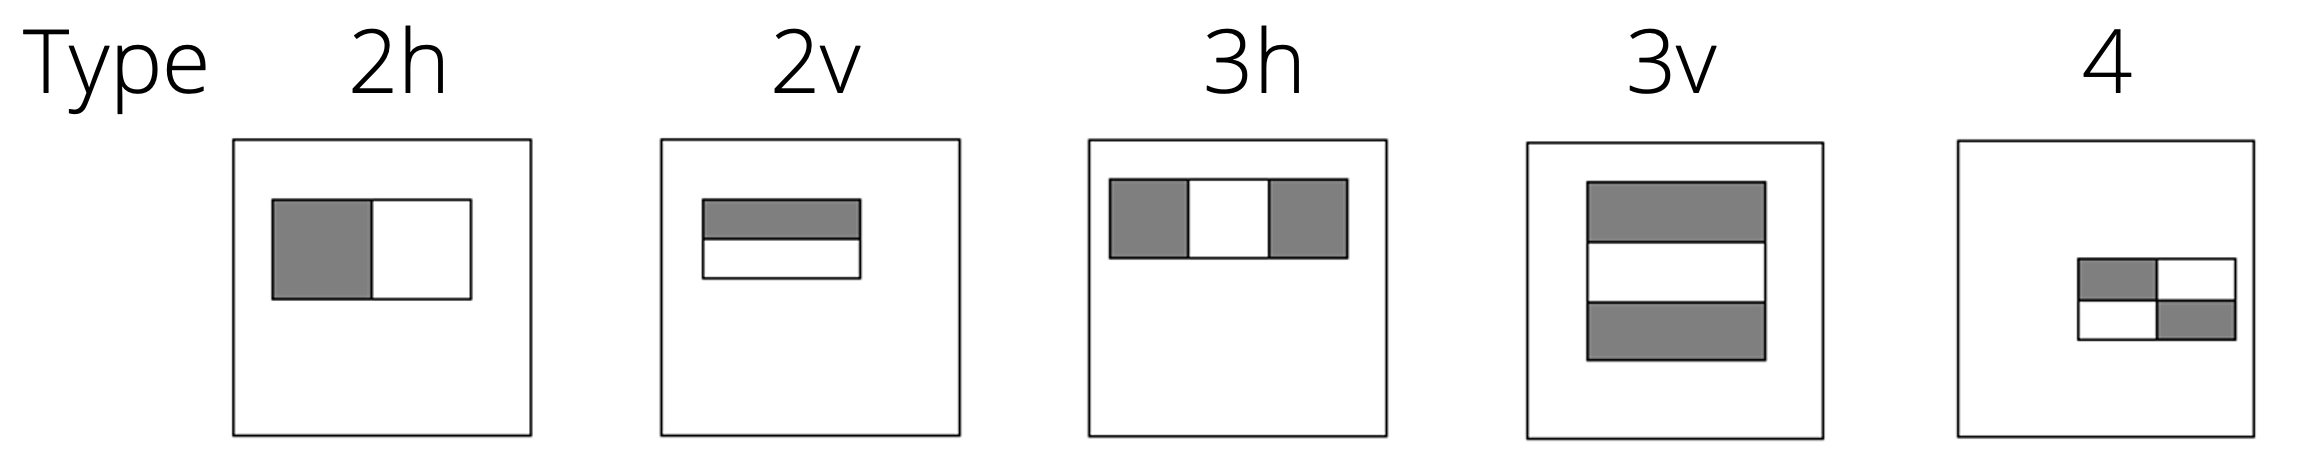

1. 위 그림과 같이 5종류의 Haar-like feature 형태를 적용하고, 각 feature 종류마다 가능한 위치/크기 값 x, y, w, h을 shape = (n_feat x 4)인 ndarray 형태로 도출하는 함수를 구현하시오.
   이때 각 feature마다 모든 사각 영역의 크기는 정수 값을 가지며, feature 종류마다 음/양 분할된 사각 영역은 반드시 동일한 크기를 갖도록 하시오.

2. 각 feature 종류별로 주어진 image dataset의 shape (n_image x w_i x h_i) ndarray 및 feature 위치/크기의 shape (n_feat x 4) ndarray에 대해 feature 값을 모두 계산하는 함수를 구현하시오. 계산된 feature 값들은 shape (n_image x n_feat)의 ndarray 형태로 도출하시오.

In [6]:
# 1. 각 feature 종류마다 가능한 위치/크기 값 x, y, w, h을 shape = (개수 x 4)인 ndarray 형태로 도출하는 함수를 구현하시오.
# 추가 : feature 갯수가 너무 많아, w, h > 4 일 feature만 사용합니다.
feat2h_ps = student.get_feature_pos_sz_2h(hlf_sz)
feat2v_ps = student.get_feature_pos_sz_2v(hlf_sz)
feat3h_ps = student.get_feature_pos_sz_3h(hlf_sz)
feat3v_ps = student.get_feature_pos_sz_3v(hlf_sz)
feat4_ps = student.get_feature_pos_sz_4(hlf_sz)

2. 각 feature 종류별로 주어진 image dataset의 shape (n_image x w_i x h_i) ndarray 및 feature 위치/크기의 shape (n_feat x 4) ndarray에 대해 feature 값을 모두 계산하는 함수를 구현하시오. 계산된 feature 값들은 shape (n_image x n_feat)의 ndarray 형태로 도출하시오.

In [7]:
LOAD_SAVE_DATA = False
if not LOAD_SAVE_DATA:
    # 2. 각 feature 종류별로 feature 값을 모두 계산하는 함수를 구현하시오. 계산된 feature 값들은 shape (n_image x n_feat)의 ndarray 형태로 도출하시오.
    feat2h = student.compute_features_2h(feat2h_ps ,iimgs)
    feat2v = student.compute_features_2v(feat2v_ps ,iimgs)
    feat3h = student.compute_features_3h(feat3h_ps ,iimgs)
    feat3v = student.compute_features_3v(feat3v_ps ,iimgs)
    feat4 = student.compute_features_4(feat4_ps ,iimgs)

    # concatenate computed features
    feat = np.column_stack(([feat2h, feat2v, feat3h, feat3v, feat4]))
    np.save("feat.npy",feat)
else:
    feat = np.load("feat.npy")
num_feat_per_type = [feat2h_ps.shape[0], feat2v_ps.shape[0], feat3h_ps.shape[0], feat3v_ps.shape[0], feat4_ps.shape[0]]
print(sum(num_feat_per_type))

20041


## 5. 각 feature 별 threshold 및 sign 도출하여 weak classifier 생성 후 에러 계산

개별 영상 $I$에 대한 feature 값 $f(I)$이 임계값 $\theta$을 초과하는지 아닌지에 따라 얼굴인지 아닌지를 판별하게 된다. 이때 $f(I)$의 특성에 따라 $\theta$을 초과하는 경우가 배경이 될 수도 있으므로, 부호(극성) p 값도 +1/-1 중에 적절한 값을 가진다.

$$
h(I, f, p, \theta) = \begin{cases} 
    1 & \text{if }  p~f(I) < p~\theta \\  
    0 & \text{otherwise}
\end{cases}
$$

위에서 계산된 feat 행렬의 열에는 전체 영상의 개별 feature 계산 값이 저장되어 있는데, 이를 이용하여 각 feature 별로 아래 식에 따라 positive & negative 영상을 구분하는 임계값과 부호를 도출해 주는 함수를 작성하시오. 

참고: 임계값과 부호를 도출할 때에는 계산된 feature 값들을 정렬하고, 정렬된 feature 값들을 순서대로 확인하면서, 해당 feature 값을 초과/미만(부호에 따라)하는 feature 값을 갖는 positive/negative 영상들의 개수(weight)들의 총합을 고려하여 정하시오. 그리고 도출된 임계값 $\theta$와 부호 $p$을 통해 feature 별로 weak classifier가 완성되므로, 각 weak classifier 별 판별 오류를 계산하도록 하시오.

In [8]:
thetas, signs, errors = student.get_weak_classifiers(feat, labels, weights)

100%|██████████| 1999/1999 [07:15<00:00,  4.59it/s]


## 6. 최적의 weak classifier 도출

위에서 산출된 error 배열을 통해 최적의 weak classifier를 도출하고, 해당 weak classifier의 haar-like feature를 영상 위에 겹쳐서 표기하는 함수 student.overlay_haar_feature를 구현하고, 임의의 얼굴 영상 샘플에 대한 overlay 결과 예시를 모니터에 띄워서 직접 눈으로 확인하시오.

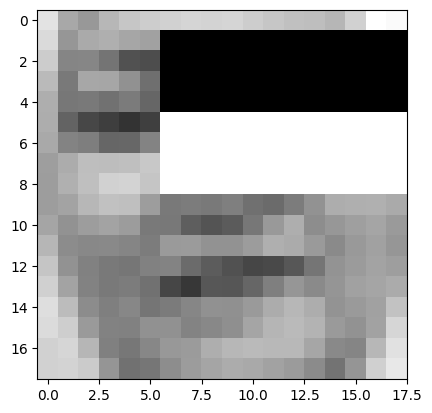

In [10]:
import random
# 3. 계산된 weak classifier 별 error 값들을 기반으로 최적의 weak classifier의 위치, 크기, 및 종류를 반환하는 함수 get_best_weak_classifier()를 구현하시오.
h_x, h_y, h_w, h_h, h_type = student.get_best_weak_classifier(errors, feat2h_ps, feat2v_ps, feat3h_ps, feat3v_ps, feat4_ps) 

img = data[random.randint(0,n_p),:,:]
# 4. 도출된 최적 weak classifier의 Haar-like feature을 임의의 얼굴 영상 위에 겹쳐서 시각화하는 함수 overlay_haar_feature()를 구현하시오.
hlf_img = student.overlay_haar_feature(hlf_sz, h_x, h_y, h_w, h_h, h_type, img/np.max(img))
plt.imshow(hlf_img, cmap='gray')

## 7. AdaBoost 알고리즘을 이용하여 상호보완적으로 weak classifier들을 조합한 strong classifier 생성

위의 과정들을 통해 이제 복수의 Haar-like feature 기반 weak classifier들을 조합한 face detector를 학습할 수 있는 도구와 데이터를 모두 갖추었다. 마지막 남은 과정은 학습 영상 별로 모두 계산된 feature 데이터 행렬을 기반으서, 개별 학습 영상의 weight를 상호보완적으로 업데이트해 가면서 최적의 weak classifier를 도출하는 과정을 반복 수행하는 것이다. 

아래 AdaBoost 알고리즘의 pseudocode를 참고하여, 다수의 weak classifier를 상호보완적으로 선택한 strong classifier를 도출하는 get_strong_classifier() 함수를 구현하시오. 이때, get_strong_classifier()의 출력은 개별 weak-classifier을 하나의 data type 형태로 정의한 class의 객체들에 대한 list가 되도록 구현하시오. 

![AdaBoost algorithm pseudocode](../image.png)

In [13]:
## 5. student.py 파일의 Haar-like classifier의 class, student.haar_weak_classifier를 정의하시오.

## 6. 개별 학습 영상의 weight을 고려하면서 최적의 weak classifier를 반복적으로 도출하여 strong classifier를 구성하는 AdaBoost 알고리즘을 
##    student.py 파일의 student.get_strong_classifier() 함수 내에 구현하시오.
##    입력 인자: 계산된 모든 feature 행렬, ground truth labels, 영상별 weights, 및 도출한 feature의 위치/크기 목록
##    출력(반환): num_weak_classifier_combination개의 student.haar_weak_classifier class 객체들로 구성된 list
num_weak_classifier_combination = 20
hwc_list = student.get_strong_classifier(feat, labels, weights,\
                                         num_feat_per_type, feat2h_ps, feat2v_ps, feat3h_ps, feat3v_ps, feat4_ps,\
                                         num_weak_classifier_combination) 

100%|██████████| 20/20 [2:28:30<00:00, 445.53s/it]


## 8. Training data에 도출된 strong classifier 적용 결과 도출하기

2번 단계에서 로딩했던 모든 학습용 database의 개별 영별에 대해 도출된 strong classifier를 적용하여 얼굴인지 아닌지에 대한 판별 결과를 list로 생성하는 함수를 구현하고 동작시키시오.

1040


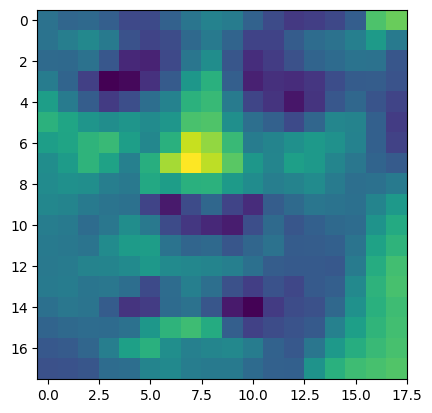

In [32]:
# 7. compute classification results for all training images data
classify_result_list = student.apply_strong_classifier_training_iimgs(iimgs, hwc_list)
# compare with ground truth labels
correctness_list = student.get_classification_correctnet(labels, classify_result_list)

# get list of all incorrect images
wrong_images = student.get_incorrect_images(data, correctness_list)
# 8. visualize sample of wrong image
ridx = random.randint(0, len(wrong_images-1))
plt.imshow(wrong_images[ridx,:,:])

print(len(wrong_images))

In [33]:
val_data_pos = student.load_folder_imgs('../data/pos', hlf_sz)[DATA_NUM:,:,:]
val_data_neg = student.load_folder_imgs('../data/neg', hlf_sz)[DATA_NUM:,:,:]
val_data = np.row_stack([val_data_pos, val_data_neg])
val_labels = np.array([val_data_pos.shape[0]*[1] + val_data_neg.shape[0]*[0]]).reshape(-1,1)
val_iimgs = student.get_integral_images(val_data)

In [34]:
test_acc = np.sum(correctness_list) / len(correctness_list)
print("Test accuracy: ", test_acc)
test_precision = classify_result_list[:len(classify_result_list)//2].sum()/classify_result_list.sum()
print("Test precision: ", test_precision)

val_classify_result_list = student.apply_strong_classifier_training_iimgs(val_iimgs, hwc_list)
val_correctness_list = student.get_classification_correctnet(val_labels, val_classify_result_list)

val_acc = np.sum(val_correctness_list) / len(val_correctness_list)
print("Validation accuracy: ", val_acc)
val_precision = val_classify_result_list[:val_data_pos.shape[0]].sum()/val_classify_result_list.sum()
print("Validation precision: ", val_precision)

Test accuracy:  0.48
Test precision:  0.5208333333333334
Validation accuracy:  0.4103420693549146
Validation precision:  0.5922536916000968


## 9. 임의의 영상에 대한 face detection 적용

임의의 영상에 대해 multi-scale, sliding window 방식으로 strong classifier를 적용하여 face detection 결과를 도출하시오.


In [25]:
# 9. load input image and run face detection using trained strong classifier
img = student.load_image()
bboxes = student.detect_face(img, hwc_list)

# visualize bboxes
bbox_img = student.visualize_bboxes(img, bboxes)
plt.imshow(bbox_img)

TypeError: unsupported operand type(s) for /: 'list' and 'float'